# Module 4 - Exercise 3: PyTorch Optimization with torch.compile

## Learning Objectives
- Understand the basics of torch.compile for model optimization
- Compare performance between compiled and non-compiled models
- Analyze the impact of batch size on optimization benefits
- Evaluate performance across different devices (CPU vs GPU)
- Learn practical optimization techniques for production models

## Environment Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
PyTorch version: 2.8.0+cu126
CUDA version: 12.6
GPU: Tesla T4


## Section 1: Understanding torch.compile with Simple Functions

In this section, we'll start with simple functions to understand how torch.compile works and measure its performance benefits.

In [9]:
def simple_computation(x: torch.Tensor) -> torch.Tensor:
    """A simple computation function for demonstration."""
    y = torch.sin(x) * torch.cos(x)
    z = y ** 2 + torch.exp(-y.abs())
    return z.sum()

# TODO: Create a compiled version of simple_computation using torch.compile
# Hint: Use torch.compile() with the function
compiled_simple_computation = torch.compile(simple_computation)

# Test both versions
test_tensor = torch.randn(1000, 1000, device=device)

# Warmup runs (important for compiled functions)
for _ in range(3):
    _ = simple_computation(test_tensor)
    if compiled_simple_computation:
        _ = compiled_simple_computation(test_tensor)

# Performance comparison
num_iterations = 100

# TODO: Measure time for non-compiled version
# Record start time, run the function num_iterations times, record end time
a = time.clock_gettime(0)
for _ in range(num_iterations):
    _ = simple_computation(test_tensor)
normal_time = time.clock_gettime(0)-a

# TODO: Measure time for compiled version
# Record start time, run the compiled function num_iterations times, record end time
a = time.clock_gettime(0)
for _ in range(num_iterations):
    _ = compiled_simple_computation(test_tensor)
compiled_time = time.clock_gettime(0)-a

if normal_time and compiled_time:
    print(f"Normal execution time: {normal_time:.4f} seconds")
    print(f"Compiled execution time: {compiled_time:.4f} seconds")
    print(f"Speedup: {normal_time/compiled_time:.2f}x")

Normal execution time: 0.0091 seconds
Compiled execution time: 0.0065 seconds
Speedup: 1.40x


## Section 2: Creating a Custom Dataset and Model

Now let's create a more realistic scenario with a dataset and a neural network model to see how torch.compile performs with real ML workloads.

In [84]:
class SyntheticDataset(Dataset):
    """A synthetic dataset for performance testing."""

    def __init__(self, num_samples: int = 10000, input_dim: int = 128):
        # TODO: Initialize the dataset with random data
        # Create self.data as random tensor of shape (num_samples, input_dim)
        # Create self.targets as random integers from 0 to 9
        self.data = torch.randn(num_samples,input_dim)
        self.targets = torch.randint(low=0, high=10, size=(num_samples,))
    def __len__(self):
        # TODO: Return the number of samples
        return len(self.data)
    def __getitem__(self, idx):
        # TODO: Return a tuple of (data, target) for the given index
        return self.data[idx], self.targets[idx]

# Create dataset
dataset = SyntheticDataset(num_samples=10000, input_dim=128)
print(f"Dataset size: {len(dataset) if dataset else 'Not implemented'}")

Dataset size: 10000


In [85]:
class OptimizedModel(nn.Module):
    """A moderately complex model for optimization testing."""

    def __init__(self, input_dim: int = 128, hidden_dim: int = 256, num_classes: int = 10):
        super().__init__()
        # TODO: Define the model architecture
        # Create a 3-layer MLP with:
        # - fc1: input_dim -> hidden_dim
        # - fc2: hidden_dim -> hidden_dim
        # - fc3: hidden_dim -> num_classes
        # - bn1, bn2: BatchNorm1d layers for hidden_dim
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,num_classes)

    def forward(self, x):
        # TODO: Implement forward pass
        # Use ReLU activation and batch normalization
        # fc1 -> bn1 -> relu -> fc2 -> bn2 -> relu -> fc3
        return self.fc3(F.relu(self.bn2(self.fc2(F.relu(self.bn1(self.fc1(x)))))))

# Create model instances
model_normal = OptimizedModel().to(device)
model_compiled = OptimizedModel().to(device)

# TODO: Compile the model_compiled using torch.compile
# Try with mode='default' first
model_compiled = torch.compile(model_compiled,mode = 'default')

print(f"Model created with {sum(p.numel() for p in model_normal.parameters())} parameters")

Model created with 102410 parameters


## Section 3: Performance Comparison with Different Batch Sizes

Let's analyze how batch size affects the performance benefits of torch.compile.

In [86]:
def benchmark_inference(model, dataloader,device=device, num_batches: int = 50) -> float:
    """Benchmark model inference performance."""
    model.eval()

    # TODO: Implement benchmarking
    # 1. Warmup with 3 batches
    # 2. Time num_batches iterations
    # 3. Return average time per batch
    avg_time = 0
    with torch.no_grad():
        # Warmup
        warmup_batches = 3
        for i, (x, _) in enumerate(dataloader):
          if i >= warmup_batches:
              break
          x=x.to(device)
          model(x)
        start_time = time.time()
        for i, (x, _) in enumerate(dataloader):
          if i >= num_batches:
              break
          x=x.to(device)
          model(x)
        end_time = time.time()
        avg_time += end_time - start_time
         # TODO: Calculate average time per batch
    return avg_time/num_batches

# Test different batch sizes
batch_sizes = [1, 4, 16, 32, 64, 128]
normal_times = []
compiled_times = []

for batch_size in batch_sizes:
    # TODO: Create DataLoader with current batch_size
    dataloader = DataLoader(SyntheticDataset(num_samples=10000, input_dim=128),batch_size=batch_size)

    if dataloader and model_normal and model_compiled:
        # Benchmark normal model
        normal_time = benchmark_inference(model_normal, dataloader)
        normal_times.append(normal_time)

        # Benchmark compiled model
        compiled_time = benchmark_inference(model_compiled, dataloader)
        compiled_times.append(compiled_time)

        print(f"Batch size {batch_size:3d}: Normal={normal_time:.4f}s, "
              f"Compiled={compiled_time:.4f}s, Speedup={normal_time/compiled_time:.2f}x")

Batch size   1: Normal=0.0006s, Compiled=0.0005s, Speedup=1.11x
Batch size   4: Normal=0.0006s, Compiled=0.0006s, Speedup=1.01x
Batch size  16: Normal=0.0007s, Compiled=0.0007s, Speedup=1.00x
Batch size  32: Normal=0.0008s, Compiled=0.0009s, Speedup=0.88x
Batch size  64: Normal=0.0011s, Compiled=0.0011s, Speedup=0.99x
Batch size 128: Normal=0.0019s, Compiled=0.0019s, Speedup=1.00x


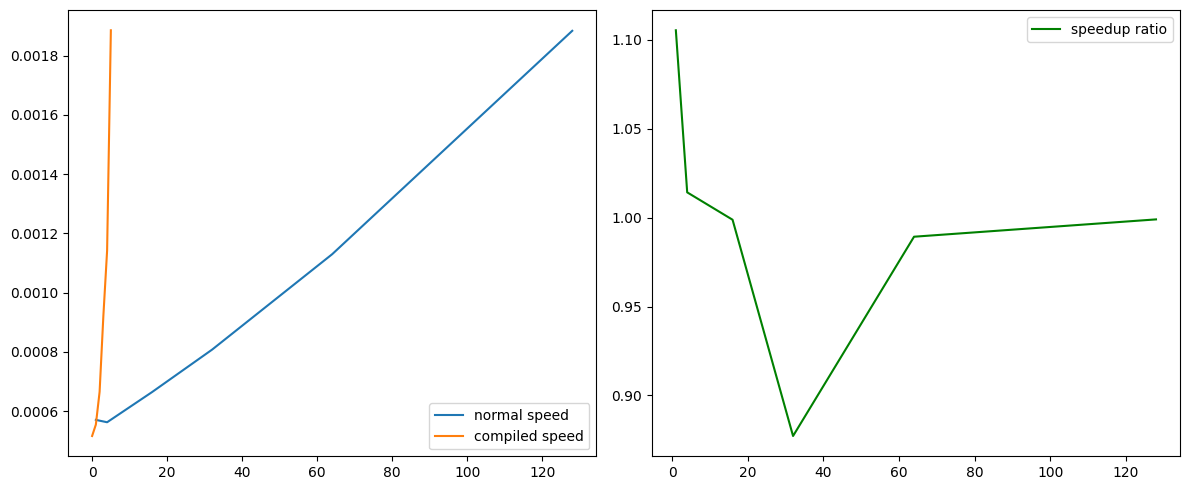

In [87]:
# Visualize the results
if normal_times and compiled_times:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # TODO: Create bar plot comparing normal vs compiled times
    ax1.plot(batch_sizes,normal_times,label = 'normal speed')
    ax1.plot(compiled_times, label = 'compiled speed')
    ax1.legend()
    # Use ax1 for the comparison

    # TODO: Create line plot showing speedup ratio across batch sizes
    # Use ax2 for the speedup plot
    ax2.plot(batch_sizes,np.array(normal_times)/np.array(compiled_times),color = 'g', label = 'speedup ratio')
    ax2.legend()
    plt.tight_layout()
    plt.show()

## Section 4: Device Comparison (CPU vs GPU)

Let's compare the optimization benefits across different devices to understand where torch.compile provides the most value.

In [88]:
def compare_devices(batch_size: int = 32, num_batches: int = 30):
    """Compare performance across CPU and GPU (if available)."""
    results = {}

    # TODO: Create a fixed dataset and dataloader
    dataset = SyntheticDataset(num_samples=1000, input_dim=128)
    dataloader = DataLoader(dataset, batch_size=batch_size)  # TODO: Create DataLoader with batch_size

    for device_name in ['cpu', 'cuda']:
        if device_name == 'cuda' and not torch.cuda.is_available():
            print("CUDA not available, skipping GPU tests")
            continue

        current_device = torch.device(device_name)
        print(f"\nTesting on {device_name.upper()}...")

        # TODO: Create and move models to current_device
        model_normal = OptimizedModel().to(current_device)
        model_compiled = OptimizedModel().to(current_device)


        if model_normal and model_compiled and dataloader:
            # Move data to device and benchmark
            device_dataloader = [(data.to(current_device), target.to(current_device))
                                for data, target in dataloader]

            # TODO: Benchmark both models
            normal_time = benchmark_inference(model_normal,device_dataloader,device = current_device)
            compiled_time = benchmark_inference(model_compiled,device_dataloader,device = current_device)

            results[device_name] = {
                'normal': normal_time,
                'compiled': compiled_time,
                'speedup': normal_time / compiled_time if compiled_time else 0
            }

    return results

# Run device comparison
device_results = compare_devices(batch_size=100000, num_batches=1)

# Display results
for device_name, metrics in device_results.items():
    print(f"\n{device_name.upper()} Results:")
    print(f"  Normal: {metrics['normal']:.4f}s")
    print(f"  Compiled: {metrics['compiled']:.4f}s")
    print(f"  Speedup: {metrics['speedup']:.2f}x")


Testing on CPU...

Testing on CUDA...

CPU Results:
  Normal: 0.0001s
  Compiled: 0.0001s
  Speedup: 1.08x

CUDA Results:
  Normal: 0.0000s
  Compiled: 0.0000s
  Speedup: 1.16x


## Section 5: Advanced Compilation Modes

torch.compile offers different modes that trade off compilation time for runtime performance. Let's explore these modes.

In [89]:
# Compilation modes to test
compile_modes = ['default', 'reduce-overhead', 'max-autotune']
mode_results = {}

# Create test data
test_dataset = SyntheticDataset(num_samples=2000, input_dim=128)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for mode in compile_modes:
    print(f"\nTesting mode: {mode}")

    # TODO: Create a fresh model and compile it with the current mode
    model = OptimizedModel().to(device)
    compiled_model = torch.compile(model,mode=mode)  # TODO: Use torch.compile with mode=mode

    if compiled_model:
        # Measure compilation + first run time
        compile_start = time.time()
        with torch.no_grad():
            for i, (data, target) in enumerate(test_loader):
                if i >= 1:  # Just one batch for compilation
                    break
                _ = compiled_model(data.to(device))
        compile_time = time.time() - compile_start

        # TODO: Benchmark runtime performance after compilation
        runtime = benchmark_inference(model,test_loader)  # TODO: Use benchmark_inference function

        mode_results[mode] = {
            'compile_time': compile_time,
            'runtime': runtime
        }

        print(f"  Compilation time: {compile_time:.2f}s")
        print(f"  Runtime per batch: {runtime:.4f}s")


Testing mode: default
  Compilation time: 0.22s
  Runtime per batch: 0.0005s

Testing mode: reduce-overhead
  Compilation time: 0.23s
  Runtime per batch: 0.0005s

Testing mode: max-autotune
  Compilation time: 0.45s
  Runtime per batch: 0.0006s


## Section 6: Training Loop Optimization

Let's see how torch.compile affects a complete training loop, including both forward and backward passes.

In [91]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    """Train model for one epoch."""
    model.train()
    total_loss = 0
    num_batches = 0

    start_time = time.time()

    for data, target in dataloader:
        # TODO: Implement training step
        # 1. Move data to device
        data = data.to(device)
        target = target.to(device)
        # 2. Zero gradients
        optimizer.zero_grad()
        # 3. Forward pass
        y_pred = model(data)

        # 4. Calculate loss
        loss = criterion(y_pred,target)
        # 5. Backward pass
        loss.backward()
        # 6. Optimizer step
        optimizer.step()

        if loss:
            total_loss += loss.item()
            num_batches += 1

    epoch_time = time.time() - start_time
    avg_loss = total_loss / num_batches if num_batches > 0 else 0

    return avg_loss, epoch_time

# Prepare training
train_dataset = SyntheticDataset(num_samples=5000, input_dim=128)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create models for training comparison
model_train_normal = OptimizedModel().to(device)
model_train_compiled = OptimizedModel().to(device)

# TODO: Compile the training model
model_train_compiled = torch.compile(model_train_compiled)

# Create optimizers and criterion
optimizer_normal = torch.optim.Adam(model_train_normal.parameters(), lr=0.001)
optimizer_compiled = torch.optim.Adam(model_train_compiled.parameters(), lr=0.001) if model_train_compiled else None
criterion = nn.CrossEntropyLoss()

# Train for a few epochs
num_epochs = 3
print("Training comparison:")
print("-" * 50)

for epoch in range(num_epochs):
    # Train normal model
    loss_normal, time_normal = train_epoch(
        model_train_normal, train_loader, optimizer_normal, criterion, device
    )

    # Train compiled model
    if model_train_compiled and optimizer_compiled:
        loss_compiled, time_compiled = train_epoch(
            model_train_compiled, train_loader, optimizer_compiled, criterion, device
        )
    else:
        loss_compiled, time_compiled = 0, 0

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Normal - Loss: {loss_normal:.4f}, Time: {time_normal:.2f}s")
    print(f"  Compiled - Loss: {loss_compiled:.4f}, Time: {time_compiled:.2f}s")
    if time_compiled > 0:
        print(f"  Speedup: {time_normal/time_compiled:.2f}x")

Training comparison:
--------------------------------------------------
Epoch 1/3:
  Normal - Loss: 2.3654, Time: 0.23s
  Compiled - Loss: 2.3765, Time: 0.26s
  Speedup: 0.87x
Epoch 2/3:
  Normal - Loss: 2.0970, Time: 0.25s
  Compiled - Loss: 2.1049, Time: 0.28s
  Speedup: 0.89x
Epoch 3/3:
  Normal - Loss: 1.9203, Time: 0.25s
  Compiled - Loss: 1.9249, Time: 0.20s
  Speedup: 1.23x
